commits:
2. Dropout_model = 0.3855,FVC_weight = 0.2,Confidence_weight = 0.2 - 6.8085
3. same but weights=0.3 - 6.8117

TODO:
- Try bigger weights
- try different lung thresholds (although its trained on-500)
- Ensemble it with the E5 version
- Train mine again on 128pix

### based on the notebook [Higher LB score by tuning mloss (around -6.811)](https://www.kaggle.com/reighns/higher-lb-score-by-tuning-mloss-around-6-811) from [Hongnan Gao](https://www.kaggle.com/reighns)  

#### Adds my Effnettrained trained using https://www.kaggle.com/khoongweihao/k-fold-tf-efficientnet-models-training

But with added features of ctscans Hist,and lung volume and augmented CTscans- from here: https://www.kaggle.com/hfutybx/osic-feature-extract-from-ct

<a class="anchor" id="0"></a>
# [OSIC Pulmonary Fibrosis Progression](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression)

# Acknowledgements from Hongnan's original NB:

* Ulrich GOUE's Osic-Multiple-Quantile-Regression-Starter
    - Model that uses images can be found at: https://www.kaggle.com/miklgr500/linear-decay-based-on-resnet-cnn
* Michael Kazachok's Linear Decay (based on ResNet CNN)
    - Model that uses tabular data can be found at: https://www.kaggle.com/ulrich07/osic-multiple-quantile-regression-starter
* Replaced Michael's model with EfficientNets B0, B2, B4
* Tuning the parameters of the models from https://www.kaggle.com/reighns/higher-lb-score-by-tuning-mloss 
* https://www.kaggle.com/leoisleo1/efficientnets-quantile-regression-inference
* https://www.kaggle.com/khoongweihao/efficientnets-quantile-regression-inference

<a class="anchor" id="0.1"></a>
## Table of Contents

1. [My upgrade](#1)
    -  [Commit now](#1.1)
    -  [Previous commits](#1.2)
1. [Import libraries](#2)
1. [Download data, auxiliary functions and model tuning](#3)
1. [Prediction and submission](#4)
    -  [Average prediction](#4.1)
    -  [Osic-Multiple-Quantile-Regression](#4.2)
    -  [The change of mloss](#4.3) 
    -  [Ensemble and blending](#4.4)

## 1. My upgrade <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [1]:
Dropout_model = 0.35
FVC_weight = 0.2
Confidence_weight = 0.2

In [2]:
EPOCHS = 10
BATCH_SIZE = 4
NFOLD = 5
LR = 0.003
SAVE_BEST = True
MODEL_CLASS = 'b1'

## 2. Import libraries <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [3]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=c6cf1662f19395a006fe00fbaf5173d1801b12cd3981c3b0993b769ce4f646d0
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=65bf91aea0a321fa7651fff80dfea8d15abbc01e601b4212094eeca23224050a
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [4]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

## 3. Download data, auxiliary functions and model tuning <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [6]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 

In [7]:
v_mean=3342 
v_stdev=1361.7
hMean_mean=-739
hMean_stdev=62.3
hSkew_mean=1.51
hSkew_stdev=0.53
hKurt_mean=2.33
hKurt_stdev=3.22

In [8]:
P=[]
for i, p in tqdm(enumerate(train.Patient.unique())):
    P.append(p)

In [9]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(8,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(Dropout_model)(x)
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    #weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
    model.load_weights('../input/k-fold-tf-efficientnet-models-training-errorhunt/Full50EpsAugHist.h5')
    return model

model_classes = ['b1'] #['b0','b1','b2','b3',b4','b5','b6','b7']
models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

Number of models: 1


In [10]:
tr_p, vl_p = train_test_split(P, shuffle=True, train_size = 0.8) 

In [11]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

# add in the ct processing of the test ct scans as a step before the model.predict step.

In [12]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image


import sys


import glob

from tqdm.auto import tqdm
#import gdcm
import pydicom

import scipy.ndimage as ndimage
from scipy.ndimage import zoom
from scipy.stats import kurtosis
from scipy.stats import skew

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset


import warnings
warnings.filterwarnings("ignore")



In [13]:
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch-master/')
sys.path.append('../input/pretrainedmodels/pretrainedmodels-0.7.4/')
sys.path.append('../input/segmentation-models-pytorch/')
import segmentation_models_pytorch as smp

In [14]:
def load_scan(path,resize_type='no'):
    """
    Loads scans from a folder and into a list.
    
    Parameters: path (Folder path)
    
    Returns: slices (List of slices)
    """
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = abs(slices[-1].ImagePositionPatient[2] - slices[0].ImagePositionPatient[2])/(len(slices))
    except:
        try:
            slice_thickness = abs(slices[-1].SliceLocation - slices[0].SliceLocation)/(len(slices))
        except:
            slice_thickness = slices[0].SliceThickness
        
    for s in slices:
        s.SliceThickness = slice_thickness
        if resize_type == 'resize':
            s.PixelSpacing = s.PixelSpacing*(s.Rows/512)  
    return slices

In [15]:
def transform_to_hu(slices):
    """
    transform dicom.pixel_array to Hounsfield.
    Parameters: list dicoms
    Returns:numpy Hounsfield
    """
    
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    #images[images <= -1000] = 0
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

In [16]:
def crop_image(img: np.ndarray):
    edge_pixel_value = img[0, 0]
    mask = img != edge_pixel_value
    return img[np.ix_(mask.any(1),mask.any(0))]

def resize_image(img: np.ndarray,reshape=(512,512)):
    img = cv2.resize(img,(512,512))
    return img

def preprocess_img(img,resize_type):
    if resize_type == 'resize':
        img = [resize_image(im) for im in img]
    if resize_type == 'crop':
        img = [crop_image(im) for im in img]
        
    return np.array(img, dtype=np.int64)

In [17]:
class Test_Generate(Dataset):
    def __init__(self,imgs_dicom,resize_type='no'):
        self.imgs_dicom = imgs_dicom
        self.resize_type = resize_type
    def __getitem__(self,index):
        
        slice_img = self.imgs_dicom[index].pixel_array
        slice_img = (slice_img-slice_img.min())/(slice_img.max()-slice_img.min())
        slice_img = (slice_img*255).astype(np.uint8)
        if self.resize_type == 'crop':
            slice_img = crop_image(slice_img)
        elif self.resize_type == 'resize':
            slice_img = cv2.resize(slice_img,(512,512))
            
        slice_img = slice_img[None,:,:]
        slice_img = (slice_img/255).astype(np.float32)
        return slice_img
        
    def __len__(self):
        return len(self.imgs_dicom)

In [18]:
device =  torch.device('cuda:0')
model = smp.Unet('densenet121', classes=1, in_channels=1,activation='sigmoid',encoder_weights=None).to(device)
model.load_state_dict(torch.load('../input/2020osic/best_lung_Unet_densenet121.pth'))
batch = 8

def Unet_mask(model: nn.Module,input_data: DataLoader):
    model.eval()
    outs = []
    for idx, sample in enumerate(test_loader):
        image = sample
        image = image.to(device)
        with torch.no_grad():
            out = model(image)
        out = out.cpu().data.numpy()
        out = np.where(out>0.5,1,0)
        out = np.squeeze(out,axis=1)
        outs.append(out)

    outs = np.concatenate(outs)
    return outs

In [19]:
def caculate_lung_volume(patient_scans,patient_masks):
    """
    caculate volume of lung from mask
    Parameters: list dicom scans,list patient CT Mask
    Returns: volume cm³　(float)
    """
    lung_volume = 0
    for i in range(len(patient_masks)):
        
        pixel_spacing = patient_scans[i].PixelSpacing
        slice_thickness = patient_scans[i].SliceThickness
        lung_volume += np.count_nonzero(patient_masks[i])*pixel_spacing[0]*pixel_spacing[1]*slice_thickness
        
    return lung_volume*0.001

In [20]:
def caculate_histgram_statistical(patient_images,patient_masks,thresh = [-600,0]):
    """
    caculate hisgram kurthosis of lung hounsfield
    Parameters: list patient CT image 512*512,thresh divide lung
    Returns: histgram statistical characteristic(Mean,Skew,Kurthosis)
    """
    statistical_characteristic = dict(Mean=0,Skew=0,Kurthosis=0)
    num_slices = len(patient_images)
    
    #patient_images = patient_images[int(num_slices*0.1):int(num_slices*0.9)]
    #patient_masks = patient_masks[int(num_slices*0.1):int(num_slices*0.9)]
    patient_images = patient_masks*patient_images
    patient_images_nonzero = patient_images[np.nonzero(patient_images)]
    
    s_pixel = patient_images_nonzero.flatten()
    s_pixel = s_pixel[np.where((s_pixel>thresh[0])&(s_pixel<thresh[1]))]
    
    statistical_characteristic['Mean'] = np.mean(s_pixel)
    statistical_characteristic['Skew'] = skew(s_pixel)
    statistical_characteristic['Kurthosis'] = kurtosis(s_pixel)
    
    return statistical_characteristic

In [21]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
device = torch.device('cuda')

test_df = pd.read_csv(f"{ROOT}/test.csv")
sample = pd.read_csv(f"{ROOT}/sample_submission.csv")
sample['Patient'] = sample['Patient_Week'].apply(lambda x:x.split('_')[0])
sample['Weeks'] = sample['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sample =  sample[['Patient','Weeks','Confidence','Patient_Week']]
sampleAndTest = sample.merge(test_df.drop('Weeks', axis=1), on="Patient")



In [22]:
test_df


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [23]:
sampleAndTest

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186855,73,Male,Ex-smoker
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186855,73,Male,Ex-smoker
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186855,73,Male,Ex-smoker
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186855,73,Male,Ex-smoker
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186855,73,Male,Ex-smoker
...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,100,ID00426637202313170790466_129,2925,71.824968,73,Male,Never smoked
726,ID00426637202313170790466,130,100,ID00426637202313170790466_130,2925,71.824968,73,Male,Never smoked
727,ID00426637202313170790466,131,100,ID00426637202313170790466_131,2925,71.824968,73,Male,Never smoked
728,ID00426637202313170790466,132,100,ID00426637202313170790466_132,2925,71.824968,73,Male,Never smoked


In [24]:
sampleAndTest.shape


(730, 9)

In [25]:
class Inference_Generate(Dataset):
    def __init__(self,imgs_dicom):
        self.imgs_dicom = imgs_dicom
        
    def __getitem__(self,index):
        metainf = self.imgs_dicom[index]
        slice_img = metainf.pixel_array
        slice_img = (slice_img-slice_img.min())/(slice_img.max()-slice_img.min())
        slice_img = (slice_img*255).astype(np.uint8)
        if metainf.Rows!=512 or metainf.Columns!=512:
            slice_img = cv2.resize(slice_img,(512,512))
            
        slice_img = slice_img[None,:,:]
        slice_img = (slice_img/255).astype(np.float32)
        return slice_img
        
    def __len__(self):
        return len(self.imgs_dicom)

In [26]:

thresh = [-500,0]
ct_root_path = '../input/osic-pulmonary-fibrosis-progression/test/'
lung_test_feature = pd.DataFrame(columns=['Patient','Volume','Mean','Skew','Kurthosis'])
for idx,i in enumerate(pd.unique(test_df['Patient'])):
    lung_test_feature.loc[idx,'Patient'] = i
    patient_scans = load_scan(ct_root_path + i)
    test_db = Inference_Generate(patient_scans)
    test_loader = DataLoader(test_db, batch_size=batch, shuffle=False, num_workers=4)
    masks = Unet_mask(model,test_loader)
    
    patient_images = transform_to_hu(patient_scans)
  
    if patient_images[0].shape!=(512,512):
        patient_images = preprocess_img(patient_images,'resize')
  
    lung_test_feature.loc[idx,'Volume'] = caculate_lung_volume(patient_scans,masks)     
    statistical_characteristic = caculate_histgram_statistical(patient_images,masks,thresh)
    lung_test_feature.loc[idx,'Mean'] = statistical_characteristic['Mean']
    lung_test_feature.loc[idx,'Skew'] = statistical_characteristic['Skew']
    lung_test_feature.loc[idx,'Kurthosis'] = statistical_characteristic['Kurthosis']


In [27]:
lung_test_feature.head()

,Patient,Volume,Mean,Skew,Kurthosis
0,ID00419637202311204720264,1246.52,-273.67,0.209798,-1.27669
1,ID00421637202311550012437,2073.8,-295.332,0.396581,-1.04897
2,ID00422637202311677017371,2719.8,-274.551,0.21486,-1.2047
3,ID00423637202312137826377,3648.07,-300.086,0.431717,-0.995569
4,ID00426637202313170790466,4231.57,-298.059,0.443857,-0.995779


In [28]:

test_df2 = test_df.merge(lung_test_feature, on='Patient')
sampleAndTestAndLungs = sampleAndTest.merge(lung_test_feature, on='Patient')


sampleAndTestAndLungs['WHERE'] = 'test'
data = sampleAndTestAndLungs

data.head()


,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus,Volume,Mean,Skew,Kurthosis,WHERE
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186855,73,Male,Ex-smoker,1246.52,-273.67,0.209798,-1.27669,test
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186855,73,Male,Ex-smoker,1246.52,-273.67,0.209798,-1.27669,test
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186855,73,Male,Ex-smoker,1246.52,-273.67,0.209798,-1.27669,test
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186855,73,Male,Ex-smoker,1246.52,-273.67,0.209798,-1.27669,test
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186855,73,Male,Ex-smoker,1246.52,-273.67,0.209798,-1.27669,test


In [29]:
sampleAndTestAndLungs.shape, data.shape

((730, 14), (730, 14))

In [30]:

data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
data['min_week']=np.nan
base = (data
    .loc[data.Weeks == data.min_week][['Patient','FVC']]
    .rename({'FVC': 'min_FVC'}, axis=1)
    .groupby('Patient')
    .first()
    .reset_index())

data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

FE = list(data.Sex.unique()) + list(data.SmokingStatus.unique())
#data = pd.concat([
 #   data,
  #  pd.get_dummies(data.Sex)
#], axis=1)

data.loc[data.Sex == 'Male','Male']=1
data.loc[data.Sex == 'Female','Male']=0
data.loc[data.SmokingStatus == 'Never smoked','smoke_1']=0
data.loc[data.SmokingStatus == 'Never smoked','smoke_2']=0
data.loc[data.SmokingStatus == 'Ex-smoker','smoke_1']=1
data.loc[data.SmokingStatus == 'Ex-smoker','smoke_2']=1
data.loc[data.SmokingStatus == 'Currently smokes','smoke_1']=0
data.loc[data.SmokingStatus == 'Currently smokes','smoke_2']=1


data['age'] = (data['Age'] - 30) / 30
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min())
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min())

data['volume'] = (data['Volume'] - v_mean)/v_stdev
data['mean'] = (data['Mean'] - hMean_mean)/hMean_stdev
data['skew'] = (data['Skew'] - hSkew_mean)/hSkew_stdev
data['kurthosis'] = (data['Kurthosis'] - hKurt_mean)/hKurt_stdev

#FE += ['age','percent','week','BASE','volume','mean','skew','kurthosis']



In [31]:
data.shape

(730, 28)

In [32]:
FE_my = ['Patient','age','volume','mean','skew','kurthosis', 'Male', 'smoke_1', 'smoke_2']

In [33]:
temp = data.loc[data.WHERE=='test']

In [34]:
test = temp[FE_my]

In [35]:
test.shape

(730, 9)

In [36]:
batch_s = 128
class Data_Generate(Dataset):
    def __init__(self,data,label=None):
        self.data = data
        self.label = label
        
    def __getitem__(self,index):
        z_ = self.data[index]
        if self.label is not None:
            y_ = self.label[index]
            y_ = y_[None,]
            return z_,y_
        else:
            return z_
         
    def __len__(self):
        return len(self.data)

In [37]:
test_tab= test.copy()

In [38]:
def get_img2(path):
    d = pydicom.dcmread(path)
    d_ia = d.pixel_array
    d_ia[d_ia<= -1000.0] = 0
    return cv2.resize((d_ia*d.RescaleSlope + d.RescaleIntercept), (512, 512))

# Inference with trained Effnet model 

I've turned off the validation steps in the below and gone straight to the test set.

In [39]:

subs = []

for model in models:
    """
    metric = []
    for q in tqdm(range(1, 10)):
        m = []
        for p in vl_p:
            x = [] 
            tab = [] 

            if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
                continue

            #print('doing predictions on validation set patient {}'.format(p))
            ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
            for i in ldir:
                if int(i[:-4]) / len(ldir) < 0.6 and int(i[:-4]) / len(ldir) > 0.3:
                    x.append(get_img2(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                    tab.append(get_tab2(hist.loc[hist.Patient == p, :])) 
                    #print(tab)
            if len(x) < 1:
                continue
            tab = np.array(tab) 

            x = np.expand_dims(x, axis=-1) 
            _a = model.predict([x, tab]) 
            a = np.quantile(_a, q / 10)

            percent_true = train.Percent.values[train.Patient == p]
            fvc_true = train.FVC.values[train.Patient == p]
            weeks_true = train.Weeks.values[train.Patient == p]

            fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
            percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
            m.append(score(fvc_true, fvc, percent))
            
        print(np.mean(m))
        metric.append(np.mean(m))

    q = (np.argmin(metric) + 1)/ 10
    print(q)
    """  
    q=0.3
    sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        print('doing predictions on patient {}'.format(p))
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                x.append(get_img2(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                #tab.append(get_tab(test.loc[test.Patient == p, :])) 
                rows=test_tab.loc[test_tab.Patient== p, :]
                vector = rows.iloc[0,1:9].values
                vector=np.array(vector,dtype=np.float) 
                tab.append(vector)
                #print(tab)
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)



doing predictions on patient ID00419637202311204720264
doing predictions on patient ID00421637202311550012437
doing predictions on patient ID00422637202311677017371
doing predictions on patient ID00423637202312137826377
doing predictions on patient ID00426637202313170790466


## 4.1 Average prediction <a class="anchor" id="4.1"></a>

[Back to Table of Contents](#0.1)

In [40]:

N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)


In [41]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3113.617884,163.804739
1,ID00421637202311550012437_-12,2850.934928,193.980219
2,ID00422637202311677017371_-12,2004.653781,151.326274
3,ID00423637202312137826377_-12,3409.895878,195.154781
4,ID00426637202313170790466_-12,2969.694053,116.519021


In [42]:
#sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

In [43]:
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

## 4.2 Osic-Multiple-Quantile-Regression <a class="anchor" id="4.2"></a>

[Back to Table of Contents](#0.1)

In [44]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [45]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [46]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [47]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [48]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [49]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [50]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [51]:

data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [52]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [53]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

## 4.3 The change of mloss <a class="anchor" id="4.3"></a>

[Back to Table of Contents](#0.1)

In [54]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [55]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [56]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [57]:
NFOLD = 5 # originally 5
kf = KFold(n_splits=NFOLD)

In [58]:
%%time
cnt = 0
EPOCHS = 855
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [34.270179748535156, 6.503944396972656]
val [40.824684143066406, 6.840489864349365]
predict val...
predict test...
FOLD 2
train [32.21866226196289, 6.459742069244385]
val [45.971282958984375, 6.9123711585998535]
predict val...
predict test...
FOLD 3
train [31.471418380737305, 6.4251203536987305]
val [47.3336181640625, 6.77154541015625]
predict val...
predict test...
FOLD 4
train [34.67753601074219, 6.539414882659912]
val [35.4544563293457, 6.561216354370117]
predict val...
predict test...
FOLD 5
train [31.494426727294922, 6.418673515319824]
val [41.016510009765625, 6.77692174911499]
predict val...
predict test...
CPU times: user 4min 29s, sys: 17.1 s, total: 4min 46s
Wall time: 4min 3s


In [59]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

146.5942020180171 228.12168883283286


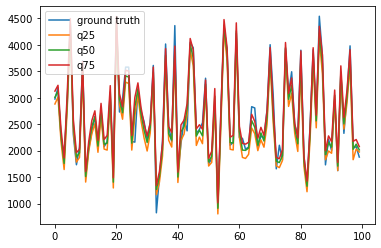

In [60]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [61]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

7.11376953125 228.12168883283286 385.447265625 1.0


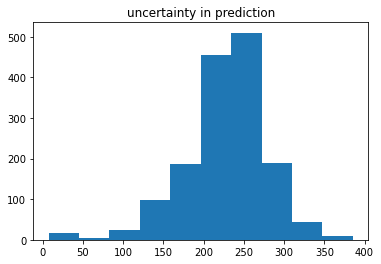

In [62]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [63]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [64]:
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2878.173340,231.459656
1541,ID00419637202311204720264_-11,3020,100.0,2875.701172,232.726379
1542,ID00419637202311204720264_-10,3020,100.0,2873.229004,233.992920
1543,ID00419637202311204720264_-9,3020,100.0,2870.756775,235.259827
1544,ID00419637202311204720264_-8,3020,100.0,2868.284607,236.526489
1545,ID00419637202311204720264_-7,3020,100.0,2865.812561,237.793213
1546,ID00419637202311204720264_-6,3020,100.0,2863.340210,239.059937
1547,ID00419637202311204720264_-5,3020,100.0,2860.868286,240.326721
1548,ID00419637202311204720264_-4,3020,100.0,2858.395996,241.593506
1549,ID00419637202311204720264_-3,3020,100.0,2855.923584,242.860107


In [65]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [66]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2878.173340,231.459656,2878.173340,231.459656
1541,ID00419637202311204720264_-11,2875.701172,232.726379,2875.701172,232.726379
1542,ID00419637202311204720264_-10,2873.229004,233.992920,2873.229004,233.992920
1543,ID00419637202311204720264_-9,2870.756775,235.259827,2870.756775,235.259827
1544,ID00419637202311204720264_-8,2868.284607,236.526489,2868.284607,236.526489


In [67]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2650.887271,329.675947,1965.739594,2593.74791,2695.742035,2829.078583,3218.260925
Confidence,730.0,285.622633,50.115316,176.767853,246.66774,287.314423,325.377510,382.054749
FVC1,730.0,2650.887271,329.675947,1965.739594,2593.74791,2695.742035,2829.078583,3218.260925
Confidence1,730.0,285.622633,50.115316,176.767853,246.66774,287.314423,325.377510,382.054749


In [68]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [69]:
#subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

In [70]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

In [71]:
reg_sub.describe()

,FVC,Confidence
count,730.000000,730.000000
mean,2651.120542,284.055233
std,330.925481,55.166038
min,1930.000000,0.100000
25%,2593.747910,246.074005
50%,2695.742035,287.314423
75%,2830.685181,325.377510
max,3294.000000,382.054749


## 4.4 Ensemble and blending <a class="anchor" id="4.4"></a>

[Back to Table of Contents](#0.1)

In [72]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [73]:
df1.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,3056.406955,106.593810
1,ID00419637202311204720264_-10,3103.215897,153.402752
2,ID00419637202311204720264_-11,3108.416890,158.603745
3,ID00419637202311204720264_-12,3113.617884,163.804739
4,ID00419637202311204720264_-2,3061.607948,111.794803


In [74]:
df2.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,2850.979370,245.393433
1,ID00419637202311204720264_-10,2873.229004,233.992920
2,ID00419637202311204720264_-11,2875.701172,232.726379
3,ID00419637202311204720264_-12,2878.173340,231.459656
4,ID00419637202311204720264_-2,2853.451599,244.126770


In [75]:
df1.describe()

,FVC,Confidence
count,730.000000,730.000000
mean,2562.140675,309.688861
std,502.231695,165.034720
min,1403.276100,70.186855
25%,2380.824977,157.767364
50%,2658.533329,292.908452
75%,2909.170856,445.510072
max,3409.895878,730.713034


In [76]:
df2.describe()

,FVC,Confidence
count,730.000000,730.000000
mean,2651.120542,284.055233
std,330.925481,55.166038
min,1930.000000,0.100000
25%,2593.747910,246.074005
50%,2695.742035,287.314423
75%,2830.685181,325.377510
max,3294.000000,382.054749


## This is the step where the 2 submissions are blended - if there is a NAN in the Effnet predictions submission (df1) then it fills them with 0.

In [77]:

df = df2[['Patient_Week','FVC','Confidence']].copy()
df['FVC'] = FVC_weight*df1['FVC'] + (1-FVC_weight)*df2['FVC']
df['Confidence'] = Confidence_weight*df1['Confidence'] + (1-Confidence_weight)*df2['Confidence']
df.head()


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,2892.064887,217.633508
1,ID00419637202311204720264_-10,2919.226382,217.874886
2,ID00419637202311204720264_-11,2922.244316,217.901853
3,ID00419637202311204720264_-12,2925.262249,217.928672
4,ID00419637202311204720264_-2,2895.082869,217.660377


In [78]:
#df2.to_csv('submission.csv', index=False)
df.to_csv('submission.csv', index=False)

In [79]:
"""
df['Patient'] = df['Patient_Week'].apply(lambda x:x.split('_')[0])
df['Weeks'] = df['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
"""

"\ndf['Patient'] = df['Patient_Week'].apply(lambda x:x.split('_')[0])\ndf['Weeks'] = df['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))\n"

In [80]:
#df.Weeks.min()

In [81]:
#df.FVC.min()

In [82]:


sample = pd.read_csv(f"{ROOT}/sample_submission.csv")
sample.describe()


,FVC,Confidence
count,730.0,730.0
mean,2000.0,100.0
std,0.0,0.0
min,2000.0,100.0
25%,2000.0,100.0
50%,2000.0,100.0
75%,2000.0,100.0
max,2000.0,100.0


In [83]:
sample.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [84]:
#df.describe()

[Go to Top](#0)